In [1]:
import sys

sys.path.append("../../src/groundstate_prep")
from fuzzy_bisection import fuzzy_bisection, fuzzy_bisection_noisy
from ground_state_prep import prepare_ground_state
from ground_state_prep_qiskit import qetu_rqc_oneLayer

sys.path.append("../../src/lindbladian")
from lindbladian import circuit_implementation_lindbladian

/Users/erenaykaracan/anaconda3/envs/qc/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/erenaykaracan/anaconda3/envs/qc/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [2]:
# Hamiltonian.

import numpy as np
from numpy import linalg as LA
import qib
import matplotlib.pyplot as plt

# Parameters for the Ising Hamiltonian
# L has to be even! Due to K only being able to control even Ls!
L, J, g = (6, 1, 1)


# construct Hamiltonian
latt = qib.lattice.IntegerLattice((L,), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
hamil = qib.IsingHamiltonian(field, J, 0, g).as_matrix().toarray()

eigenvalues, eigenvectors = LA.eig(hamil)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]
print("Ground State Energy", eigenvalues_sort[0].real)

dist = 0.001
max_spectrum_length = 16
ground_energy_lower_bound = -10
c1 = (np.pi-2*dist) / (max_spectrum_length)
c2 = dist - c1 * ground_energy_lower_bound

eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])

print("a_max", a_values[0])
print("a_premax", a_values[1])
print("c1: ", c1)
print("c2: ", c2)

Ground State Energy -7.72740661031253
a_max (0.9751344744696506-0j)
a_premax (0.9690846890527381-0j)
c1:  0.19622454084936208
c2:  1.9632454084936208


Absolute Error for the Eigenvalue:  0.5830838054621958


/Users/erenaykaracan/anaconda3/envs/qc/lib/python3.10/site-packages/matplotlib/ticker.py:799: ComplexWarning: Casting complex values to real discards the imaginary part
  loc_range_oom = int(math.floor(math.log10(loc_range)))
/Users/erenaykaracan/anaconda3/envs/qc/lib/python3.10/site-packages/matplotlib/ticker.py:525: ComplexWarning: Casting complex values to real discards the imaginary part
  else fmt % arg)
/Users/erenaykaracan/anaconda3/envs/qc/lib/python3.10/site-packages/matplotlib/text.py:895: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
/Users/erenaykaracan/anaconda3/envs/qc/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/erenaykaracan/anaconda3/envs/qc/lib/python3.10/site-packages/matplotlib/text.py:754: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = flo

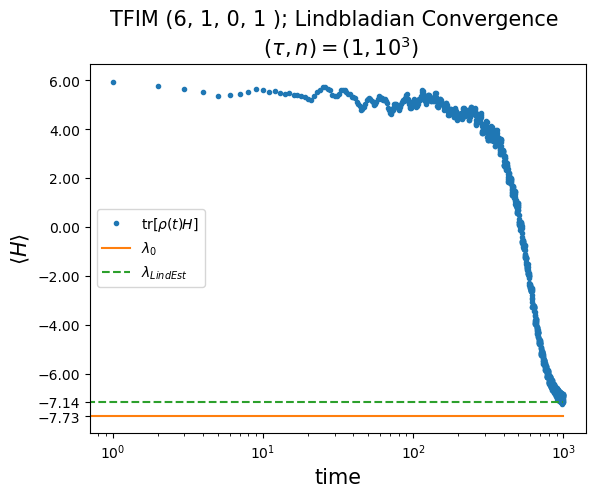

dt:  0.09811227042468104
Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.27509349682562917+0j)
F(a_premax)^2:  (0.12854592188162323+0j)

Layer 0
Prob 0: 0.2199371770224047
Prob 1: 0.780062822977595
0.9118524155919251

Layer 1
Prob 0: 0.2621291975590178
Prob 1: 0.7378708024409811
0.956849264855153

Layer 2
Prob 0: 0.2687415201488442
Prob 1: 0.7312584798511546
0.9793617331813697

Layer 3
Prob 0: 0.27204028088405646
Prob 1: 0.7279597191159421
0.9902487178748677

Layer 4
Prob 0: 0.2736355431408187
Prob 1: 0.7263644568591802
0.9954195206188761

F(a_max) = (0.27509349682562917+0j)

 ---------- 
 SUCCESS! 

Fidelity of the initial state to the ground state: 0.7291029018103746
Fidelity of the prepared state to the ground state: 0.9954195206188761


In [4]:
# Prepare the ground state with Lindbladian + QETU

mu, d, c, phis_max_iter, = (0.97, 30, 0.9, 10)

tau, nsteps = (1,1000)
end_state_lind, en_list, err = circuit_implementation_lindbladian(hamil, L, tau=tau, nsteps=nsteps)

print("Absolute Error for the Eigenvalue: ", err)
plt.semilogx(tau * np.arange(nsteps + 1), en_list, ".", label=r"$\mathrm{tr}[\rho(t) H]$")
plt.semilogx(tau * np.arange(nsteps + 1), (eigenvalues_sort[0]*np.ones(nsteps + 1)).real, label=r"$\lambda_0$")
plt.semilogx(tau * np.arange(nsteps + 1), ((eigenvalues_sort[0] + 0.58308)*np.ones(nsteps + 1)).real, ls="--",
            label=r"$\lambda_{LindEst}$")
plt.legend()
plt.xlabel("time", size=15)
plt.ylabel(r"$\langle H \rangle$", size=15)
plt.title("TFIM (6, 1, 0, 1 ); Lindbladian Convergence \n " + r"$ (\tau, n) = (1, 10^3) $", size=15)
plt.yticks([-8+2*i for i in range(1, 8)] + [eigenvalues_sort[0] + 0.58308]  + [eigenvalues_sort[0]])
plt.savefig("../../theory/pdf/TFIM_6_lind.pdf")
plt.show()


qc_qetu, phis_0, _ = qetu_rqc_oneLayer(L, J, g, c1/2, mu, a_values, d=d, 
                                       c=c, c2=c2, max_iter_for_phis=phis_max_iter,
                                       )

ket_0 = np.array([1,0])

end_state_qetu, E = prepare_ground_state(
                        np.kron(ket_0, end_state_lind), mu, d, c, phis_max_iter,
                        np.kron(ket_0, ground_state), L, J, g, eigenvalues_sort[0],
                        hamil=hamil, max_reps=5, tau=c1, shift=c2, a_max=a_values[0]
)



In [ ]:
# We can make max_spectrum_length arbitrarily small and approximate the eigenvalue
# digit by digit. This increases the c1 every time by 10 times, hence increasing circuit
# depth by 10 times. RQCOpt can fix this!

previous_estimate = -8

x_exp = []
for digit in range(0, 6):
    dist = 1e-20
    print("Target Digit: ", -digit)
    max_spectrum_length = 10**(-digit)
    previous_estimate = np.round(previous_estimate, digit)
    print("Previous Estimate: ", previous_estimate)
    ground_energy_lower_bound = previous_estimate - max_spectrum_length
    c1 = (np.pi-2*dist) / (max_spectrum_length)
    c2 = dist - c1 * ground_energy_lower_bound
    print("c1 ", c1)
    print("c2 ", c2)

    eigenvalues_tr = eigenvalues_sort * c1 + c2
    a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])
    
    # Assuming we can approximate a_max up to one digit 
    # precision after comma at each fuzzy bisection search.
    a_est = np.round(a_values[0], 2)
    est_eig = 2*np.arccos(a_est)
    print("ground_energy_lower_bound", ground_energy_lower_bound)
    #print("lambda-lambda_LB * 10^(-d}):", (eigenvalues_sort[0] - ground_energy_lower_bound)/max_spectrum_length)
    x_exp.append((eigenvalues_sort[0] - ground_energy_lower_bound)/max_spectrum_length)
    previous_estimate = (est_eig - c2)/c1
    print("exact a", a_values[0])
    print("Estimated a: ", a_est)
    #print("Estimated x:", 2/np.pi*np.arccos(a_est))
    print("Estimated Eigenvalue: ", previous_estimate)
    print("Exact Eigenvalue", eigenvalues_sort[0])
    print("Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
    print("----------------------------------------")

In [7]:
# We go one digit further, assuming we know the lower bound to be -7.75 through previous
# approximations!

dist = 0.001
max_spectrum_length = 1

# Initial search starts with a larger margin, hence multiplication with 2!
# Estimation -6 is acquired through expectation value measurement!
ground_energy_lower_bound = -6 - 2*max_spectrum_length
c1 = (np.pi-2*dist) / (max_spectrum_length)
c2 = dist - c1 * ground_energy_lower_bound
c2 = c2

eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])

a_est = 0.89
est_eig = 2*np.arccos(a_est)
print("Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
print("Estimated Eigenvalue: ", (est_eig - c2)/c1)
print("Exact a: ", a_values[0])

print("c1: ", c1)

Absolute Error:  (0.028688470385234588+0j)
Estimated Eigenvalue:  -7.698718139927295
Exact a:  (0.9096248901196278-0j)
c1:  3.1395926535897933


In [ ]:
# Divide up the time step and repeat the circuit! Depolarizing error: 1e-3!

a_est = fuzzy_bisection_noisy(qc_qetu, L, J, g, 0, 1, 34, 1e-3, 0, c1, c2, a_values, 1e-3, RQC_layers=7, qetu_initial_state=np.kron(ket_0, end_state_lind), nshots=1e4, split_U=1, qetu_layers=5, ground_state=eigenvectors_sort[:, 0])
print("Estimated a: " + str(a_est))
print("a: " + str(a_values[0]))

In [17]:
# We demonstrate that we approximated the eigenvalue until the third digit!

a_est = 0.88
est_eig = 2*np.arccos(a_est)
print("Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
print("Estimated Eigenvalue: ", (est_eig - c2)/c1)

0.88
0.989868252681791
Absolute Error:  (0.04237366552942934+0j)
Estimated Eigenvalue:  -7.6850329447831


In [19]:
# We go one digit further, assuming we know the lower bound to be -7.75 through previous
# approximations!

dist = 0.001
max_spectrum_length = 0.1
ground_energy_lower_bound = -7.7 - max_spectrum_length
c1 = (np.pi-2*dist) / (max_spectrum_length)
c2 = dist - c1 * ground_energy_lower_bound
c2 = c2

eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])

a_est = 0.42
est_eig = 2*np.arccos(a_est)
print("Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
print("Estimated Eigenvalue: ", (est_eig - c2)/c1)
print("Exact a: ", a_values[0])
print("c1:", c1)

Absolute Error:  (-0.00017310258906899634+0j)
Estimated Eigenvalue:  -7.727579712901599
Exact a:  (0.41753238442639495-0j)
c1: 31.39592653589793


In [ ]:
# Divide up the time step and repeat the circuit! Depolarizing error: 1e-3!

a_est = fuzzy_bisection_noisy(qc_qetu, L, J, g, 0,  1, 34, 1e-3, 0, c1, c2, a_values, 1e-3, qetu_initial_state=np.kron(ket_0, end_state_lind), nshots=1e4, qetu_layers=5, ground_state=eigenvectors_sort[:, 0])
print("Estimated a: " + str(a_est))
print("a: " + str(a_values[0]))

------------------
x: 0.5
d:  34
left:  0
right:  1
dt:  1.046530884529931
Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.0003072071007159508+0j)
Time evolution encoding, absolute error:  0.0007169184480852605
state_fidelity: 0.9954195255150531
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'cx', 'cu', 'cz', 'cy', 'rz', 'sx', 'u3', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3', 'rz', 'sx', 'cu', 'cx', 'cy', 'cz']
Success Prob:  0.2423
------------------
x: 0.255
d:  34
left:  0
right:  0.51
dt:  1.046530884529931
Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.7738906386765607+0j)
Time evolution encoding, absolute error:  0.0007169184480852605
state_fidelity: 0.9954195255150529
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'cx', 'cu', 'cz', 'cy', 'rz', 'sx', 'u3', 'u1']
  All-

In [27]:
# We demonstrate that we approximated the eigenvalue until the third digit!

a_est = 0.40046875
est_eig = 2*np.arccos(a_est)
print(a_est)
print(est_eig)
print("Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
print("Estimated Eigenvalue: ", (est_eig - c2)/c1)

0.40046875
2.317535950861689
Absolute Error:  (0.00034445633475588266+0j)
Estimated Eigenvalue:  -7.727062153977774


In [20]:
# We go one digit further, assuming we know the lower bound to be -7.7271 through previous
# approximations!

dist = 0.001
max_spectrum_length = 0.001
ground_energy_lower_bound = -7.727 - max_spectrum_length
c1 = (np.pi-2*dist) / (max_spectrum_length)
c2 = dist - c1 * ground_energy_lower_bound
c2 = c2

eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])

a_est = 0.55
est_eig = 2*np.arccos(a_est)
print("Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
print("Estimated Eigenvalue: ", (est_eig - c2)/c1)
print("Exact a: ", a_values[0])
print("c1", c1)

Absolute Error:  (3.594806295126318e-05+0j)
Estimated Eigenvalue:  -7.727370662249578
Exact a:  (0.5962287837278712-0j)
c1 3139.5926535897934


In [ ]:
# Divide up the time step and repeat the circuit! Depolarizing error: 1e-3!

a_est = fuzzy_bisection_noisy(qc_qetu, L, J, g, 0,  1, 34, 1e-3, 0, c1, c2, a_values, 1e-3, qetu_initial_state=np.kron(ket_0, end_state_lind), nshots=1e4, split_U=20, RQC_layers=11, qetu_layers=5, ground_state=eigenvectors_sort[:, 0])
print("Estimated a: " + str(a_est))
print("a: " + str(a_values[0]))

------------------
x: 0.5
d:  34
left:  0
right:  1
dt:  78.48981633974483
Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.8890779306204775+0j)
Time evolution encoding, absolute error:  2.832633071363232e-06
state_fidelity: 0.9954195254166436
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'cy', 'cu', 'u2', 'u1', 'cx', 'cz', 'sx', 'rz']
  All-qubits errors: ['u1', 'u2', 'u3', 'rz', 'sx', 'cu', 'cx', 'cy', 'cz']
Success Prob:  0.7444
------------------
x: 0.745
d:  34
left:  0.49
right:  1
dt:  78.48981633974483
Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.003284468931710479+0j)
Time evolution encoding, absolute error:  2.832633071363232e-06
state_fidelity: 0.995419525416645
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'cy', 'cu', 'u2', 'u1', 'cx', 'cz', 'sx', 'rz']
  All-qu

In [6]:
# The run above will get stuck around the given interval.
# We demonstrate that we approximated the eigenvalue until the fourth digit!

a_est = 0.5765625
est_eig = 2*np.arccos(a_est)
print("Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
print("Estimated Eigenvalue: ", (est_eig - c2)/c1)

Absolute Error:  (1.5467072699060225e-05+0j)
Estimated Eigenvalue:  -7.727391143239831


In [4]:
# We go one digit further, assuming we know the lower bound to be -7.72741 through previous
# approximations!

dist = 0.001
max_spectrum_length = 0.0001
ground_energy_lower_bound = -7.7274 - max_spectrum_length
c1 = (np.pi-2*dist) / (max_spectrum_length)
c2 = dist - c1 * ground_energy_lower_bound
c2 = c2

eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])

a_est = 0.15
est_eig = 2*np.arccos(a_est)
print("Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
print("Estimated Eigenvalue: ", (est_eig - c2)/c1)
print("Exact a: ", a_values[0])

print("c1: ", c1)

Absolute Error:  (-2.9494163484855562e-06+0j)
Estimated Eigenvalue:  -7.727409559728878
Exact a:  (0.10407961312991994-0j)
c1:  31395.926535897932


In [ ]:
# Divide up the time step and repeat the circuit! Depolarizing error: 1e-3!

a_est = fuzzy_bisection_noisy(qc_qetu, L, J, g, 0,  1, 34, 1e-3, 0, c1, c2, a_values, 1e-3, qetu_initial_state=np.kron(ket_0, end_state_lind), nshots=1e4, split_U=20, RQC_layers=11, qetu_layers=5, ground_state=eigenvectors_sort[:, 0])
print("Estimated a: " + str(a_est))
print("a: " + str(a_values[0]))

------------------
x: 0.5
d:  34
left:  0
right:  1
dt:  784.8981633974483
Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.0002008680662934722+0j)
Time evolution encoding, absolute error:  6.844680321282185e-07
state_fidelity: 0.9954195286252543
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['cu', 'sx', 'rz', 'u3', 'cz', 'u2', 'u1', 'cx', 'cy']
  All-qubits errors: ['u1', 'u2', 'u3', 'rz', 'sx', 'cu', 'cx', 'cy', 'cz']
Success Prob:  0.2444
------------------
x: 0.255
d:  34
left:  0
right:  0.51
dt:  784.8981633974483
Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.002652606784816739+0j)
Time evolution encoding, absolute error:  6.844680321282185e-07
state_fidelity: 0.9954195286252563
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['cu', 'sx', 'rz', 'u3', 'cz', 'u2', 'u1', 'cx', 'cy']
  Al

In [5]:
# The run above will get stuck around the given interval.
# We demonstrate that we approximated the eigenvalue until the fifth digit!

a_est = 0.07125
est_eig = 2*np.arccos(a_est)
print("Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
print("Estimated Eigenvalue: ", (est_eig - c2)/c1)

Absolute Error:  (2.0995093699127665e-06+0j)
Estimated Eigenvalue:  -7.72740451080316


In [5]:
# We go one digit further, assuming we know the lower bound to be -7.727401 through previous
# approximations!

dist = 0.001
max_spectrum_length = 1e-5
ground_energy_lower_bound = -7.72740 - max_spectrum_length
c1 = (np.pi-2*dist) / (max_spectrum_length)
c2 = dist - c1 * ground_energy_lower_bound
c2 = c2

eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])

a_est = 0.8
est_eig = 2*np.arccos(a_est)
print("Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
print("Estimated Eigenvalue: ", (est_eig - c2)/c1)
print("Exact a: ", a_values[0])

print("c1: ", c1)


Absolute Error:  (7.063923694872187e-07+0j)
Estimated Eigenvalue:  -7.72740590392016
Exact a:  (0.8614837293906226-0j)
c1:  313959.2653589793


In [ ]:
# Divide up the time step and repeat the circuit! Depolarizing error: 1e-3!

a_est = fuzzy_bisection_noisy(qc_qetu, L, J, g, 0,  1, 34, 1e-3, 0, c1, c2, a_values, 1e-3, qetu_initial_state=np.kron(ket_0, end_state_lind), nshots=1e4, split_U=20, RQC_layers=9, qetu_layers=5, ground_state=eigenvectors_sort[:, 0])
print("Estimated a: " + str(a_est))
print("a: " + str(a_values[0]))

------------------
x: 0.5
d:  34
left:  0
right:  1
dt:  7848.981633974482
Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.870910253455057+0j)
Time evolution encoding, absolute error:  7.938896053190815e-07
state_fidelity: 0.9954195252396205
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['sx', 'u3', 'cx', 'u2', 'cy', 'rz', 'u1', 'cz', 'cu']
  All-qubits errors: ['u1', 'u2', 'u3', 'rz', 'sx', 'cu', 'cx', 'cy', 'cz']
Success Prob:  0.7155
------------------
x: 0.745
d:  34
left:  0.49
right:  1
dt:  7848.981633974482
Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.7931231502309293+0j)
Time evolution encoding, absolute error:  7.938896053190815e-07
state_fidelity: 0.9954195252396207
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['sx', 'u3', 'cx', 'u2', 'cy', 'rz', 'u1', 'cz', 'cu']
  All-qubi

In [6]:
# The run above will get stuck around the given interval.
# We demonstrate that we approximated the eigenvalue until the sixth digit!

a_est = 0.836875
est_eig = 2*np.arccos(a_est)
print("Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
print("Estimated Eigenvalue: ", (est_eig - c2)/c1)

Absolute Error:  (2.970783006261968e-07+0j)
Estimated Eigenvalue:  -7.727406313234229


In [23]:
# We go one digit further, assuming we know the lower bound to be -7.75 through previous
# approximations!

dist = 0.001
max_spectrum_length = 0.1
ground_energy_lower_bound = -4.71 - max_spectrum_length
c1 = (np.pi-2*dist) / (max_spectrum_length)
c2 = dist - c1 * ground_energy_lower_bound
c2 = c2

eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])

a_est = -0.23
est_eig = 2*np.arccos(a_est)
print("Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
print("Estimated Eigenvalue: ", (est_eig - c2)/c1)
print("Exact a: ", a_values[0])
print("c1:", c1)

# Divide up the time step and repeat the circuit! Depolarizing error: 1e-2!
# As noise goes up, we shoot more shots: 1e5
#a_est = fuzzy_bisection_noisy(qc_qetu, L, J, g, 0,  1, 18, 1e-3, 0, c1, c2, a_values, 1e-2, qetu_initial_state=np.kron(ket_0, end_state_lind), nshots=1e5, split_U=1, RQC_layers=5, qetu_layers=5, ground_state=eigenvectors_sort[:, 0])

Absolute Error:  (3.0322223974877733+0j)
Estimated Eigenvalue:  -4.695184212824756
Exact a:  (-0.2413418426424419+0j)
c1: 31.39592653589793


In [19]:
# The run above will get stuck around the given interval.
# We demonstrate that we approximated the eigenvalue until the sixth digit!

a_est = 0.5
est_eig = 2*np.arccos(a_est)
print("Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
print("Estimated Eigenvalue: ", (est_eig - c2)/c1)

Absolute Error:  (2.4951349858379928+0j)
Estimated Eigenvalue:  -5.232271624474537


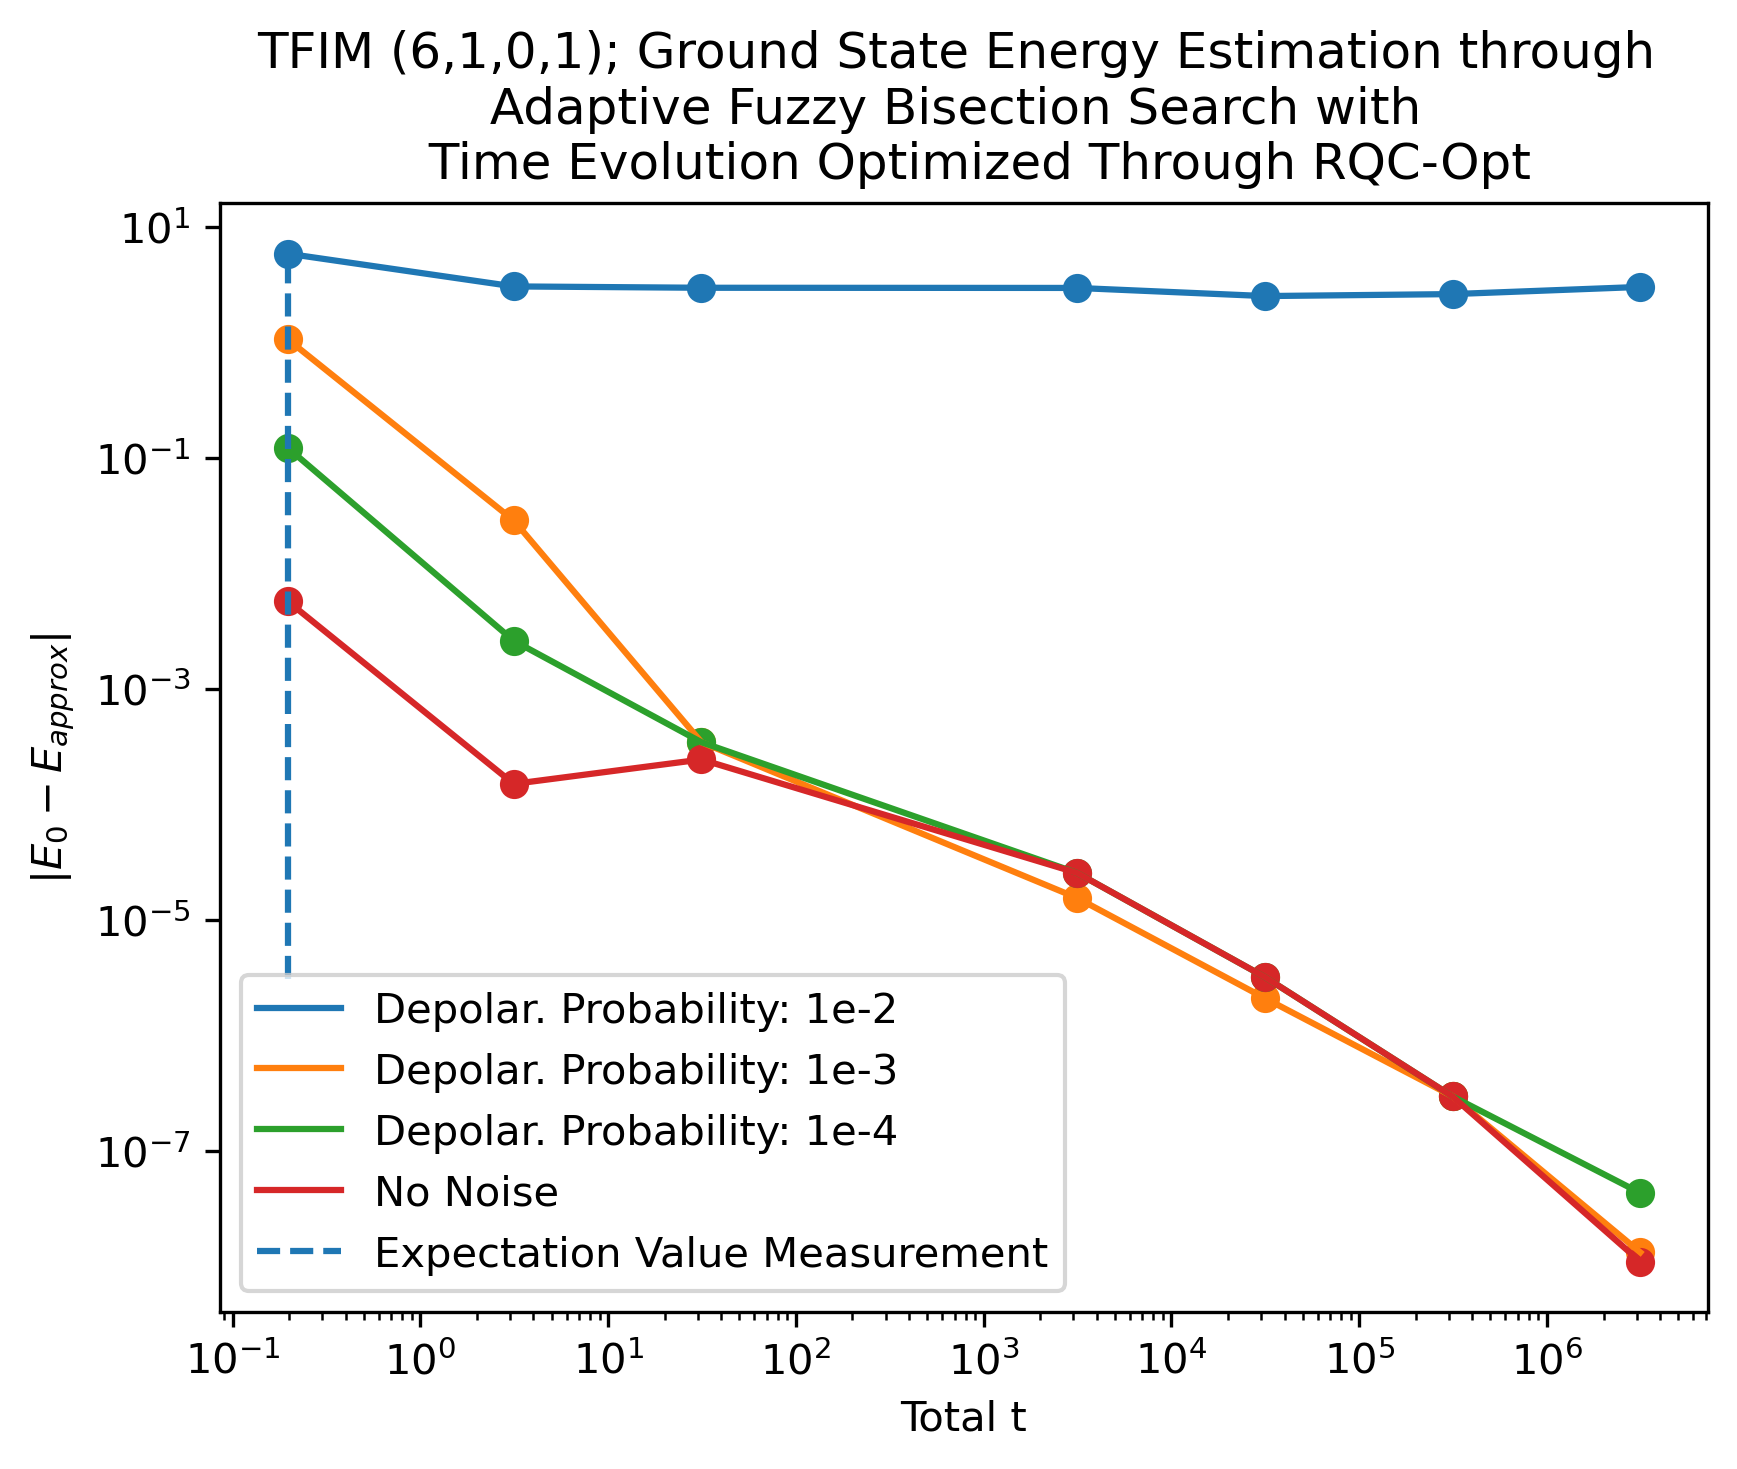

In [130]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

time_steps = [0.196, 3.1395, 31.396, 3139.593, 31395.93, 313959.265, 3139592.65]
abs_errors_e3 = [1.06, 0.0286, 3.44e-4, 1.547e-05, 2.1e-06, 2.97e-07, 1.324e-08]
abs_errors_e2 = [5.82, 3.03, 2.95, 2.94, 2.5, 2.6, 3]
abs_errors_e4 = [0.122, 0.0026, 3.44e-4, 2.547e-05, 3.2e-06, 2.96e-07, 4.324e-08]
abs_errors_ideal = [0.00573, 1.5e-4, 2.44e-4, 2.547e-05, 3.2e-06, 2.96e-07, 1.1e-08]

plt.yscale('log')
plt.xscale('log')

plt.xlabel("Total t")
plt.ylabel(r"$ |E_{0} - E_{approx}| $")
plt.title("TFIM (6,1,0,1); Ground State Energy Estimation through \n Adaptive Fuzzy Bisection Search with  \n  Time Evolution Optimized Through RQC-Opt")
plt.plot(time_steps, abs_errors_e2, label="Depolar. Probability: 1e-2")
plt.plot(time_steps, abs_errors_e3, label="Depolar. Probability: 1e-3")
plt.plot(time_steps, abs_errors_e4, label="Depolar. Probability: 1e-4")
plt.plot(time_steps, abs_errors_ideal, label="No Noise")
plt.axvline(x=time_steps[0], ymin=0.3, ymax=0.95, ls="--", label="Expectation Value Measurement")

plt.scatter(time_steps, abs_errors_e2)
plt.scatter(time_steps, abs_errors_e3)
plt.scatter(time_steps, abs_errors_e4)
plt.scatter(time_steps, abs_errors_ideal)
plt.legend()


plt.savefig("../../theory/pdf/TFIM_6_errors.pdf")

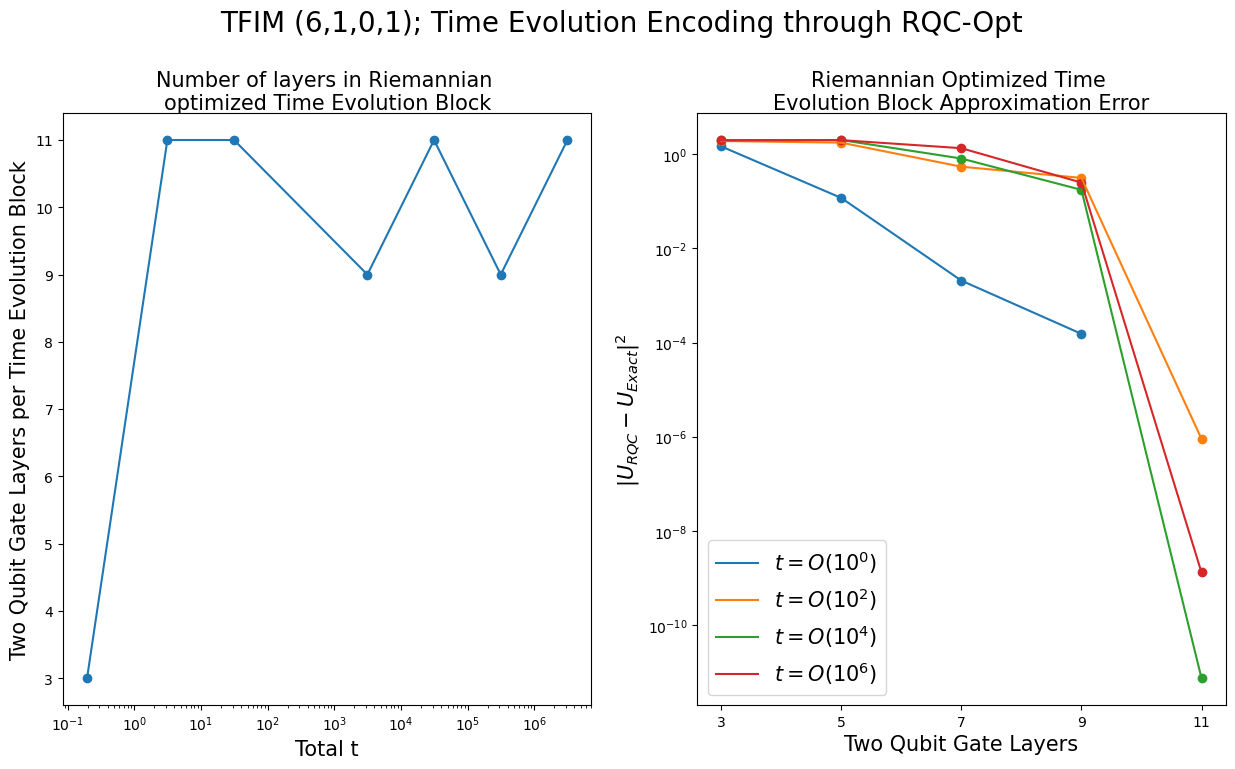

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(15)
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.85, wspace=None, hspace=None)

fig.suptitle("TFIM (6,1,0,1); Time Evolution Encoding through RQC-Opt \n", size=20)

layers_per_U = [3, 11, 11, 9, 11, 9, 11]
time_steps = [0.196, 3.1395, 31.396, 3139.593, 31395.93, 313959.265, 3139592.65]
split_U = [1, 1, 1, 1, 10, 20]
ax[0].set_xlabel("Total t", size=15)
ax[0].set_ylabel("Two Qubit Gate Layers per Time Evolution Block", size=15)
ax[0].set_title("\nNumber of layers in Riemannian \noptimized Time Evolution Block", size=15, pad=0
            )
ax[0].set_xscale('log')
ax[0].plot(time_steps, layers_per_U)
ax[0].scatter(time_steps, layers_per_U)


e0_errors = [1.4673780604426576, 0.11787, 0.00207, 0.00015286]
e1_errors = [1.9367, 1.88929, 1.0728, 0.4026, 7.001941729267846e-07]
e2_errors = [1.9089, 1.7577, 0.543115, 0.313473, 8.968270389908361e-07]
e3_errors = [1.98, 1.87, 1.51, 9.740398622760286e-07]
e4_errors = [1.996, 1.9997, 0.80950, 0.174918, 7.421320655220531e-12]
e5_errors = [1.6555021, 1.4940,  0.92547, 1.0232778955765669e-07]
e6_errors = [ 1.96825383719572, 1.9907755958568265, 1.342, 0.24956, 1.3069352008163319e-09]

ax[1].set_yscale("log")
ax[1].set_xticks([3,5,7,9,11])
ax[1].set_ylabel(r"$ | U_{RQC} - U_{Exact} |^2 $", size=15)
ax[1].set_xlabel("Two Qubit Gate Layers", size=15)
ax[1].plot([2*i+3  for i in range(len(e0_errors))], e0_errors, label=r"$ t = O(10^0) $")
#ax[1].plot([2*i+3  for i in range(len(e1_errors))], e1_errors, label=r"$ dt = O(10^1) $")
ax[1].plot([2*i+3  for i in range(len(e2_errors))], e2_errors, label=r"$ t = O(10^2) $")
#ax[1].plot([2*i+3  for i in range(len(e3_errors))], e3_errors, label=r"$ dt = O(10^3) $")
ax[1].plot([2*i+3  for i in range(len(e4_errors))], e4_errors, label=r"$ t = O(10^4) $")
#ax[1].plot([2*i+3  for i in range(len(e5_errors))], e5_errors, label=r"$ dt = O(10^5) $")
ax[1].plot([2*i+3  for i in range(len(e6_errors))], e6_errors, label=r"$ t = O(10^6) $")

ax[1].scatter([2*i+3  for i in range(len(e0_errors))], e0_errors)
#ax[1].scatter([2*i+3  for i in range(len(e1_errors))], e1_errors)
ax[1].scatter([2*i+3  for i in range(len(e2_errors))], e2_errors)
#ax[1].scatter([2*i+3  for i in range(len(e3_errors))], e3_errors)
ax[1].scatter([2*i+3  for i in range(len(e4_errors))], e4_errors)
#ax[1].scatter([2*i+3  for i in range(len(e5_errors))], e5_errors)
ax[1].scatter([2*i+3  for i in range(len(e6_errors))], e6_errors)
ax[1].set_title("\nRiemannian Optimized Time \nEvolution Block Approximation Error", size=15, pad=-10)
ax[1].legend(loc="lower left", prop={'size': 15})

plt.savefig("../../theory/pdf/RQC_L6.pdf")

<>:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/l7/gymj72ps13bdlz98t43mc96c0000gn/T/ipykernel_11802/321456199.py:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if d is not 1:
/Users/erenaykaracan/anaconda3/envs/qc/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/erenaykaracan/anaconda3/envs/qc/lib/python3.10/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Users/erenaykaracan/anaconda3/envs/qc/lib/python3.10/site-packages/matplotlib/text.py:1461: ComplexWarning: Casting complex values to real discards the imaginary part
  x = float(self.convert_xunits(x))
/Users/erenaykaracan/anaconda3/envs/qc/lib/python3.10/site-packages/matplotlib/text.py:753: C

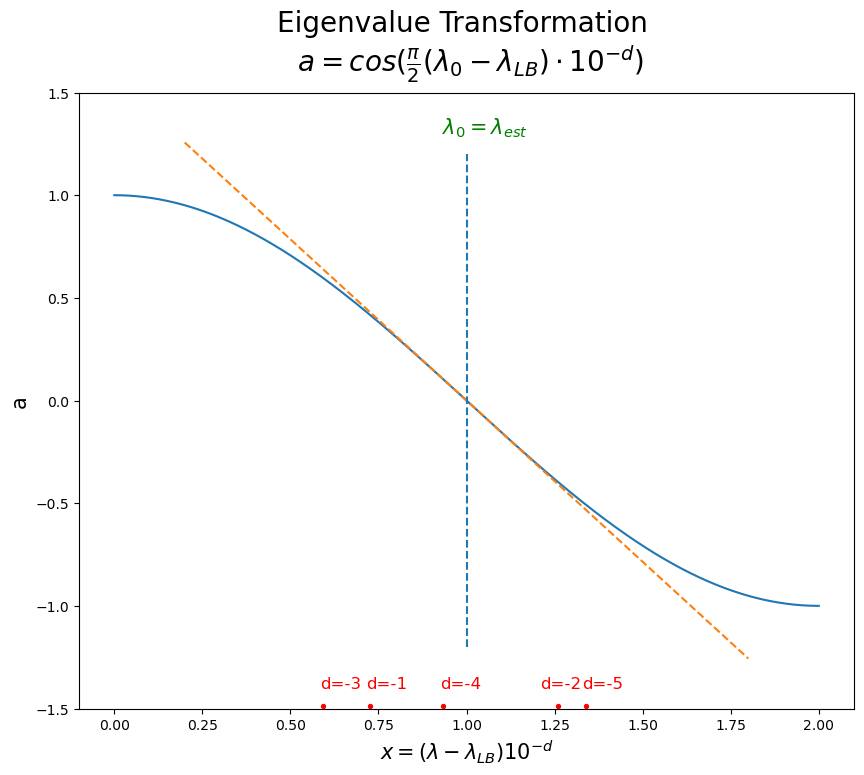

In [22]:
x_values = np.linspace(0, 2, 1001)
plt.figure(figsize=(10, 8))
plt.ylabel("a", size=15)
plt.xlabel(r'$ x = (\lambda-\lambda_{LB}) 10^{-d} $', size=15) 
plt.plot(x_values, np.cos(np.pi/2 * x_values))
plt.title("Eigenvalue Transformation \n" + r" $ a = cos(\frac {\pi}{2}(\lambda_0-\lambda_{LB}) \cdot 10^{-d}) $", 
          size=20, pad=15)

plt.plot(x_values[100:-100], -np.pi/2 * (x_values[100:-100]-1), ls="--")

for d, x in enumerate(x_exp[1:]):
    if d is not 1:
        plt.annotate(f"d={-(d+1)}", xy=(x-0.01,-1.4), color="red", size=12)
    else:
        plt.annotate("d=-2", xy=(x-0.05,-1.4), color="red", size=12)
plt.axvline(x=1, ymin=0.1, ymax=0.9, ls="--", label="Expectation Value Measurement")
plt.annotate(r"$ \lambda_0 = \lambda_{est} $", xy=(0.93,1.3), color="green", size=15)

plt.scatter(x_exp[1:], [-1.49 for i in range(len(x_exp)-1)], s=8, color="red")
plt.ylim([-1.5, 1.5])

plt.savefig("../../theory/pdf/cos_slope.pdf")

# d=-1 means: First digit after floating point is known, we are trying to estimate the second digit etc. 

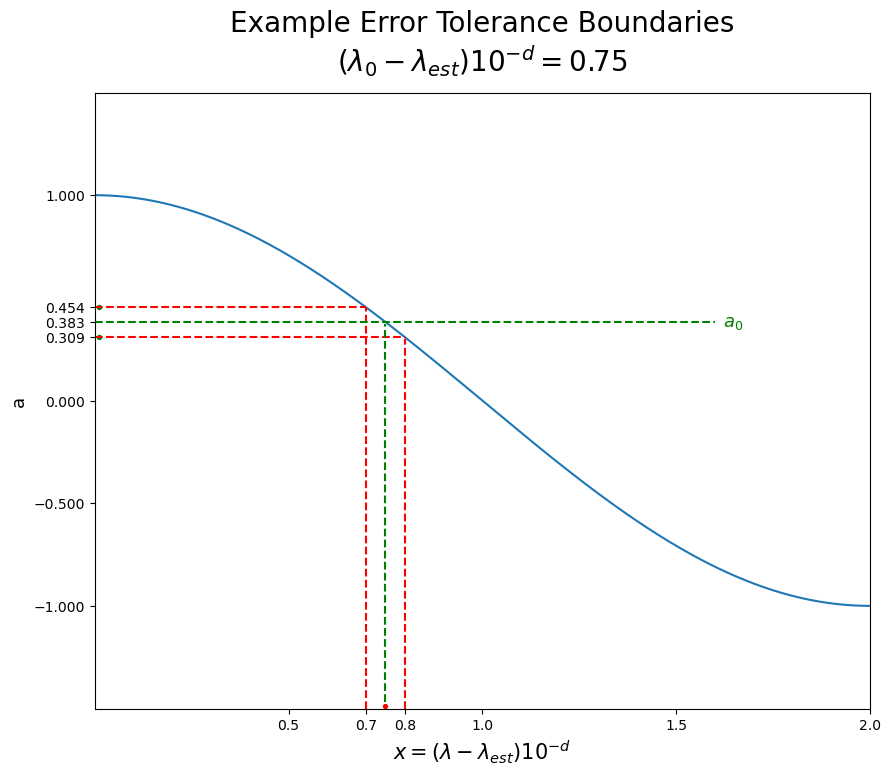

In [21]:
x_values = np.linspace(0, 2, 1001)
plt.figure(figsize=(10, 8))
plt.ylabel("a", size=13)
plt.xlabel(r'$ x = (\lambda-\lambda_{est}) 10^{-d} $', size=15) 
plt.plot(x_values, np.cos(np.pi/2 * x_values))
plt.title("Example Error Tolerance Boundaries\n" + r"$ (\lambda_0-\lambda_{est}) 10^{-d} = 0.75 $",
         size=20, pad=15)

plt.scatter([0.75], [-1.49], s=8, color="red")
#plt.annotate("(", xy=(0.75-0.05, -1.49), color="red")
#plt.annotate(")", xy=(0.75+0.05, -1.49), color="red")
plt.ylim([-1.5, 1.5])
plt.xlim([0, 2])

plt.axvline(x=0.75-0.05, ymin=0, ymax=0.65, ls="--", color="red")
plt.axvline(x=0.75+0.05, ymin=0, ymax=0.6, ls="--", color="red")

plt.axhline(y= np.cos(np.pi/2 * 0.7), xmin=0, xmax= 0.7/2, ls="--", color="red")
plt.axhline(y= np.cos(np.pi/2 * 0.8), xmin=0, xmax= 0.8/2, ls="--", color="red")
plt.axhline(y= np.cos(np.pi/2 * 0.75), xmin=0, xmax= 0.8, ls="--", color="green")
plt.annotate(r"$a_0$", xy=(1.62, np.cos(np.pi/2 * 0.75)-0.02), color="green", size=13)
plt.axvline(x=0.75, ymin=0.01, ymax=0.625, ls="--", color="green")

plt.yticks([np.cos(np.pi/2 * 0.8), np.cos(np.pi/2 * 0.7), 1, -1, 0, -0.5, np.cos(np.pi/2 * 0.75)])
plt.xticks([0.5, 0.7, 0.8, 1, 1.5, 2])

plt.scatter([0.01, 0.01], [np.cos(np.pi/2 * 0.7), np.cos(np.pi/2 * 0.8)], color="green", s=8)

plt.savefig("../../theory/pdf/cos_boundaries.pdf")
# d=-1 means: First digit after floating point is known, we are trying to estimate the second digit etc. 

In [82]:
# We go one digit further, assuming we know the lower bound to be -7.727407 through previous
# approximations!

dist = 0.001
max_spectrum_length = 1e-6
ground_energy_lower_bound = -7.727406 - max_spectrum_length
c1 = (np.pi-2*dist) / (max_spectrum_length)
c2 = dist - c1 * ground_energy_lower_bound
c2 = c2

eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])

a_est = 0.8
est_eig = 2*np.arccos(a_est)
print("Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
print("Estimated Eigenvalue: ", (est_eig - c2)/c1)
print("Exact a: ", a_values[0])

print("c1: ", c1)
a_est = fuzzy_bisection_noisy(qc_qetu, L, J, g, 0,  1, 34, 1e-3, 0, c1, c2, a_values, 1e-3, qetu_initial_state=np.kron(ket_0, end_state_lind), nshots=1e4, split_U=1, RQC_layers=11, qetu_layers=5, ground_state=eigenvectors_sort[:, 0])

Absolute Error:  (1.9920513238957938e-08+0j)
Estimated Eigenvalue:  -7.727406590392016
Exact a:  (0.8183685094204864-0j)
c1:  3139592.6535897935
------------------
x: 0.5
d:  34
left:  0
right:  1
dt:  1569796.3267948967
Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.8544763634246062+0j)
Time evolution encoding, absolute error:  7.158123285508512e-07
state_fidelity: 0.995419528478941
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['cz', 'cy', 'rz', 'u3', 'u2', 'cu', 'cx', 'u1', 'sx']
  All-qubits errors: ['u1', 'u2', 'u3', 'rz', 'sx', 'cu', 'cx', 'cy', 'cz']
Success Prob:  0.7081
------------------
x: 0.745
d:  34
left:  0.49
right:  1
dt:  1569796.3267948967
Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.8879823714950285+0j)
Time evolution encoding, absolute error:  7.158123285508512e-07
state_fidelity: 0.9954195284789388
NoiseModel:
  Basis gates: ['cu',

In [83]:
# The run above will get stuck around the given interval.
# We demonstrate that we approximated the eigenvalue until the sixth digit!

a_est = 0.80625
est_eig = 2*np.arccos(a_est)
print("Absolute Error: ", (est_eig - c2)/c1 - eigenvalues_sort[0])
print("Estimated Eigenvalue: ", (est_eig - c2)/c1)

Absolute Error:  (1.3237976936864015e-08+0j)
Estimated Eigenvalue:  -7.727406597074553


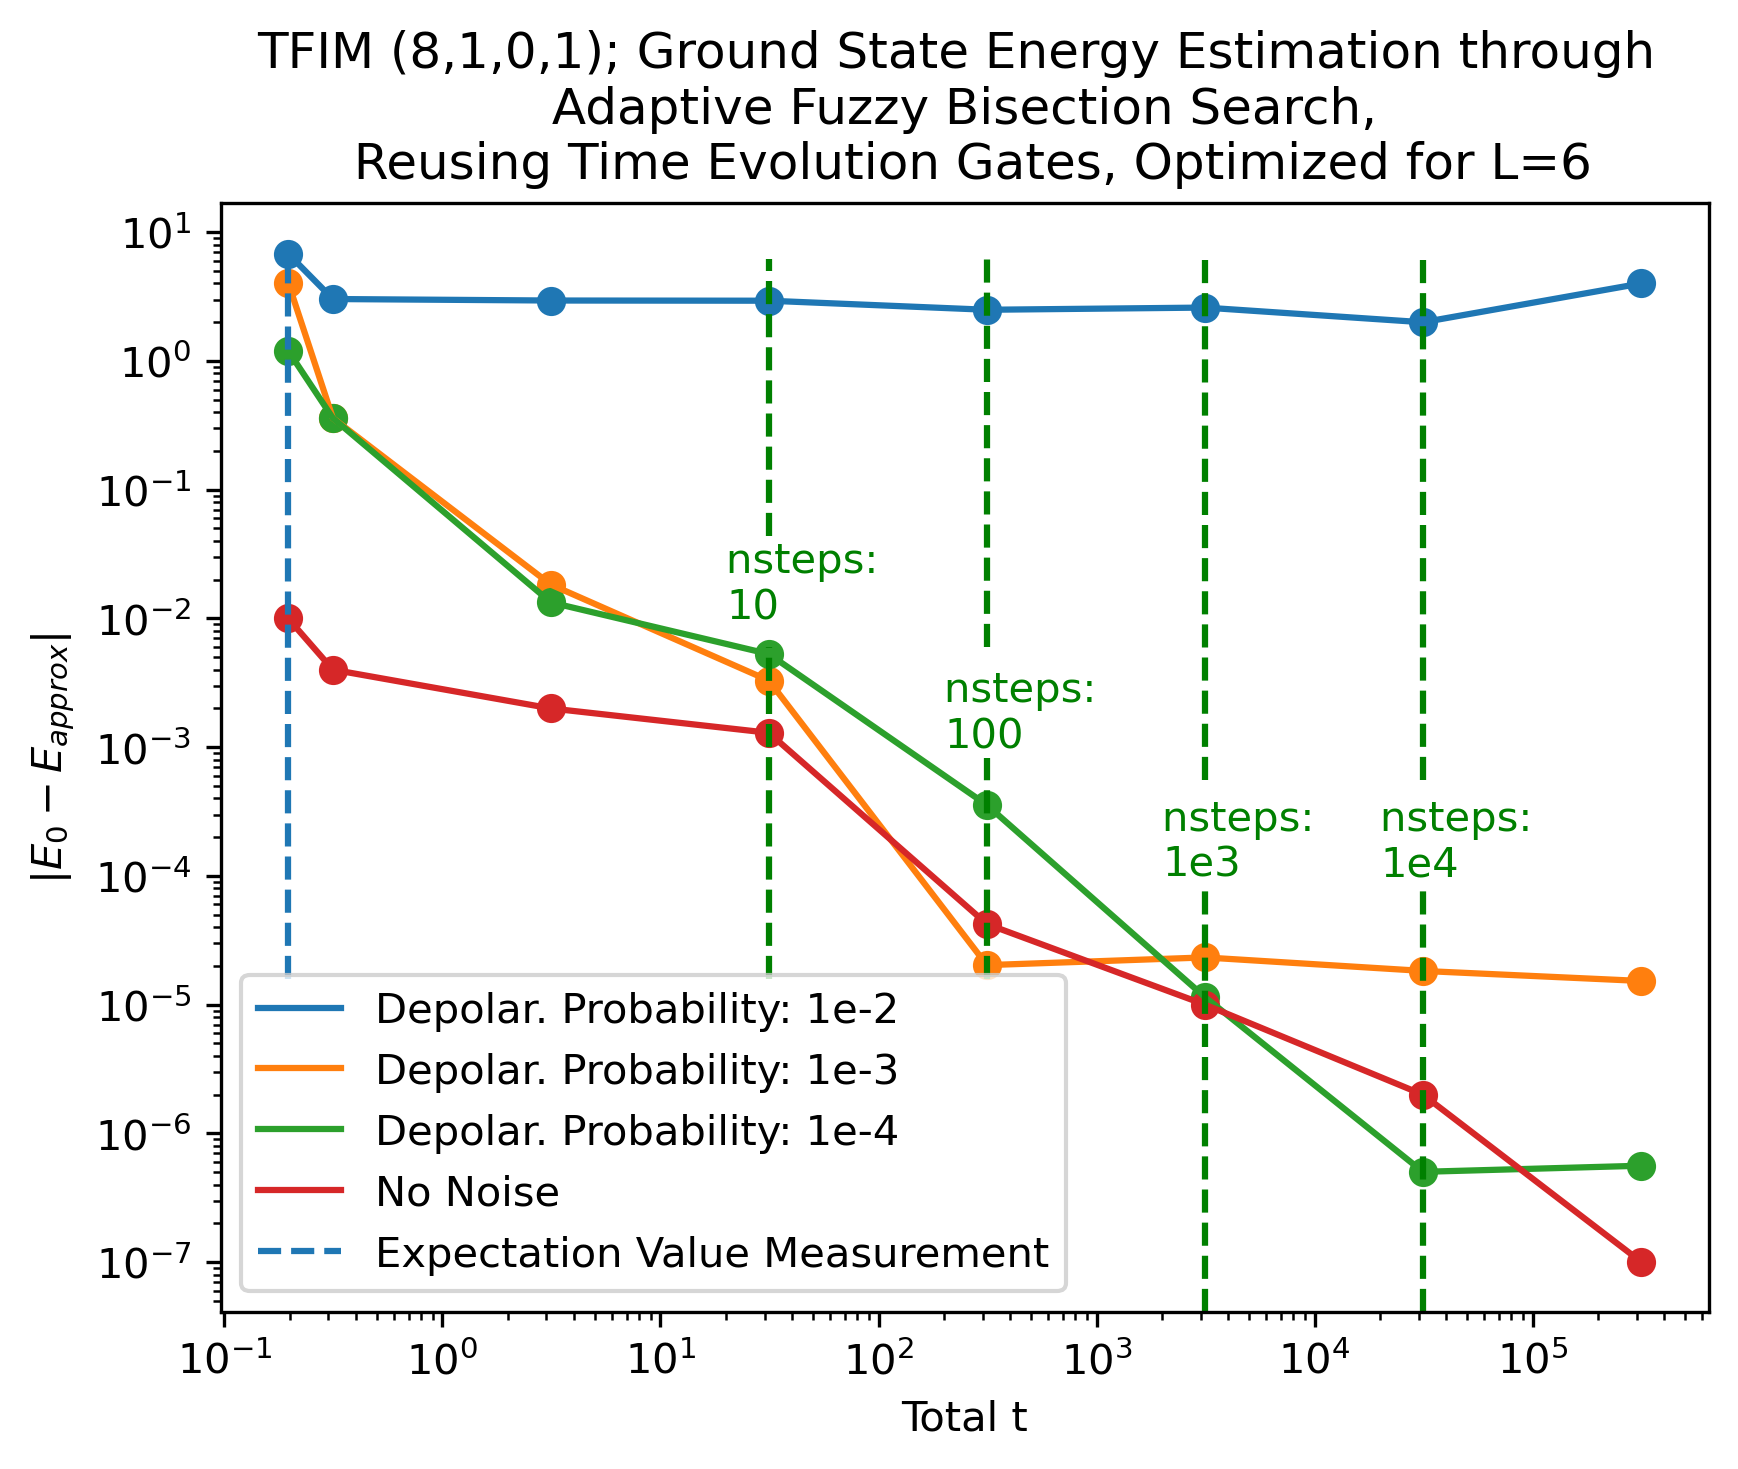

In [85]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

time_steps = [0.196, 0.31415926, 3.1415, 31.41592653, 314.1592653, 3141.592653, 31415.92653, 314159.2653]
abs_errors_e3 = [4.0638, 0.36, 0.018328457, 0.0032937, 2.0281505008767908e-05, 2.328e-05, 1.828e-05, 1.528e-05]
abs_errors_e4 = [1.2, 0.36, 0.013328457, 0.0052937, 0.000355531, 1.14564954016339e-05, 5.02818e-07, 5.60818e-07]
abs_errors_ideal = [1e-2, 4e-3, 2e-3, 0.0012937, 4.2281505008767908e-05, 1.001e-05, 2.001e-06, 1.00818e-07]
abs_errors_e2 = [6.82, 3.03, 2.95, 2.94, 2.5, 2.6, 2, 4]


plt.yscale('log')
plt.xscale('log')

plt.xlabel("Total t")
plt.ylabel(r"$ |E_{0} - E_{approx}| $")
plt.title("TFIM (8,1,0,1); Ground State Energy Estimation through \n Adaptive Fuzzy Bisection Search, \n Reusing Time Evolution Gates, Optimized for L=6")
plt.plot(time_steps, abs_errors_e2, label="Depolar. Probability: 1e-2")
plt.plot(time_steps, abs_errors_e3, label="Depolar. Probability: 1e-3")
plt.plot(time_steps, abs_errors_e4, label="Depolar. Probability: 1e-4")
plt.plot(time_steps, abs_errors_ideal, label="No Noise")
plt.axvline(x=time_steps[0], ymin=0.3, ymax=0.95, ls="--", label="Expectation Value Measurement")
plt.axvline(x=time_steps[3], ymin=0.3, ymax=0.6, ls="--", color="green")
plt.axvline(x=time_steps[3], ymin=0.7, ymax=0.95, ls="--", color="green")
plt.axvline(x=time_steps[4], ymin=0.3, ymax=0.5, ls="--", color="green")
plt.axvline(x=time_steps[4], ymin=0.6, ymax=0.95, ls="--", color="green")
plt.axvline(x=time_steps[5], ymin=0, ymax=0.38, ls="--", color="green")
plt.axvline(x=time_steps[5], ymin=0.48, ymax=0.95, ls="--", color="green")
plt.axvline(x=time_steps[6], ymin=0, ymax=0.38, ls="--", color="green")
plt.axvline(x=time_steps[6], ymin=0.48, ymax=0.95, ls="--", color="green")

plt.annotate("nsteps: \n10", xy = (20, 1e-2), color="green")
plt.annotate("nsteps: \n100", xy = (200, 1e-3), color="green")
plt.annotate("nsteps: \n1e3", xy = (2e3, 1e-4), color="green")
plt.annotate("nsteps: \n1e4", xy = (2e4, 1e-4), color="green")

plt.scatter(time_steps, abs_errors_e2)
plt.scatter(time_steps, abs_errors_e3)
plt.scatter(time_steps, abs_errors_e4)
plt.scatter(time_steps, abs_errors_ideal)
plt.legend()

plt.savefig("../../theory/pdf/TFIM_8_errors.pdf")